# Proof-of-concept TR-RB simulation

Tim Keil

In [1]:
# ~~~
# This file is part of PhD-thesis:
#
#           "Adaptive Reduced Basis Methods for Multiscale Problems
#               and Large-scale PDE-constrained Optimization"
#
# by: Tim Keil
#
#   https://github.com/TiKeil/Supplementary-Material-for-PhD-thesis
#
# Copyright 2019-2022 all developers. All rights reserved.
# License: Licensed as BSD 2-Clause License (http://opensource.org/licenses/BSD-2-Clause)

# Preparations

## details

In this notebook we discretize the following problem: 
Find $u_{\mu}$ solving the following parametrized constrained equation

\begin{align*}
	-  \nabla \cdot \left( \kappa_{\mu}  \nabla u_{\mu} \right) &= f_{\mu} &&\text{in } \Omega, \\
	q ( \kappa_{\mu}  \nabla u_{\mu} \cdot n) &= (u_{\text{out}} - u_{\mu}) &&\text{on } \partial \Omega.
\end{align*}

For the definition of $\kappa_{\mu}$ and $f_{\mu}$ in the computational domain $\Omega$, we use the `BitmapFunction` from PyMOR. This function uses the Python Imaging Library (PIL) in order to convert a .png grayscale picture to a data function on our domain.
Walls, windows and doors are stored in seperated .png to enable a affine decomposition of each part of the picture. Furthermore, we are considering a heater at each window. The numbering of the components for $\kappa_{\mu}$ can be seen in the following picture
![EXC_notebook_data/EXC_MM_with_numbers.png](EXC_notebook_data/Domain_of_interestin_Omega.png)

Here, numbers with | are walls, numbers with _ are doors and numbers with dots are windows

The heaters are numbered in the following way:
![EXC_notebook_data/EXC_MM_with_numbers_heat.png](EXC_notebook_data/EXC_MM_with_numbers_heat.png)

For our pde constrained model, we need to define a cost functional. In a general quadratic model, we have 

\begin{align}
\mathcal{J}(u, \mu) := \Theta(\mu) + j_\mu(u) + k_\mu(u, u),
\end{align}

For this code, we restrict ourselves to the following definition
\begin{align}
\mathcal{J}(v, \mu) = \frac{\sigma_d}{2} \int_{D}^{} (v - u^{\text{d}})^2 + \frac{1}{2} \sum^{M}_{i=1} \sigma_i \mu_i^2,
\end{align}
which means

\begin{align}
\Theta(\mu) &= \frac{1}{2} \sum^{M}_{i=1} \sigma_i \mu_i^2 + \frac{\sigma_d}{2} \int_{D}^{} u^{\text{d}} u^{\text{d}}\\
j_{\mu}(u) & = -\sigma_d \int_{D}^{} u^{\text{d}}u \\
k_{\mu}(u,u) &= \frac{\sigma_d}{2} \int_{D}^{} u^2 
\end{align}

The following code implements this particular case.

## prepare cells

In [2]:
import numpy as np

from matplotlib import pyplot as plt

from pymor.basic import *

In [3]:
from pymor.core.logger import set_log_levels, getLogger
set_log_levels({'pymor': 'ERROR',
                'distributed_adaptive_discretizations': 'DEBUG',
                'notebook': 'INFO'})
logger = getLogger('notebook.notebook')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300

data_path = '../EXC_data'
# domain of interest
bounding_box = [[0,0],[2,1]]
domain_of_interest = BitmapFunction('{}/Domain_of_interest.png'.format(data_path), range=[1,0], bounding_box=bounding_box)

## problem definition and tolerances

In [4]:
from pdeopt.problems import EXC_problem, set_input_dict
from pdeopt.discretizer import discretize_quadratic_pdeopt_stationary_cg_EXC

parametric_quantities = {'walls': [1,4], 'windows': [], 'doors': [], 'heaters': []}
inactive_quantities = {'removed_walls': [], 'open_windows': [], 'open_doors': [1,2,3,4,5,6,7,10],
                       'active_heaters': [9]}
summed_quantities = {'walls': [[1,2,3,8],[4,5,6]], 'windows': [], 'doors': [], 'heaters': [[9,1,5]]}

coefficient_expressions = None
parameters_in_q = True

input_dict = set_input_dict(parametric_quantities, inactive_quantities, coefficient_expressions, summed_quantities, parameters_in_q,
                            ac=0.5, owc=[0.0005], iwc= [0.005,0.1], idc=[0.005], wc=[0.0005], ht=[0,100],
                                    owc_c=0.025,  iwc_c= 0.001,     idc_c=0.01,  wc_c=0.025,  ht_c=80)


parameter_scaling = False
u_out = 5

problem, parameter_scales = EXC_problem(input_dict, summed_quantities, outside_temperature=u_out, #, q_inverse=0.0001
                                        data_path = data_path,parameters_in_q=parameters_in_q, 
                                        parameter_scaling=parameter_scaling,
                                        coefficient_expressions=coefficient_expressions)

u_d = 18 

mu_d = problem.parameter_space.sample_randomly(1, seed=10)[0]
mu_d = None

sigma_d = 1
weights = {'walls': 10, 'doors': 1, 'heaters': 1, 'windows': 1, 'state': 1.}

diameter = np.sqrt(2)/200.
opt_fom, data, mu_bar = discretize_quadratic_pdeopt_stationary_cg_EXC(problem, diameter, weights, parameter_scales, 
                                                          domain_of_interest, desired_temperature=u_d, 
                                                          mu_for_u_d=mu_d, mu_for_tikhonov=mu_d,
                                                          parameters_in_q=parameters_in_q, product='fixed_energy')

I am using the NCD corrected functional!!
my product is fixed_energy
mu_bar is: {walls: [0.022360679774997897, 0.022360679774997897]}


In [5]:
print('information on the grid:')
print(data['grid'])

radius = 0.1               # TR radius 
FOC_tolerance = 1e-6       # tau_FOC
sub_tolerance = 1e-8       # tau_sub
safety_tol = 1e-16         # Safeguard, to avoid running the optimizer for really small difference in digits
max_it = 40                # Maximum number of iteration for the TR algorithm
max_it_sub = 400           # Maximum number of iteration for the TR optimization subproblem
max_it_arm = 50            # Maximum number of iteration for the Armijo rule
init_step_armijo = 0.5     # Initial step for the Armijo rule
armijo_alpha = 1e-5       # kappa_arm
beta = 0.95                # beta_2
epsilon_i = 1e-8           # Treshold for the epsilon active set (Kelley '99)

# additional parameters for Newton
iterative_solver = 'BICGStab'
estimate_tolerance = 1e-4
Qian_Grepl_subproblem = True
control_mu = False
reductor_type = 'simple_coercive'

information on the grid:
Rect-Grid on domain [0,2] x [0,1]
x0-intervals: 400, x1-intervals: 200
faces: 80000, edges: 160600, vertices: 80601


In [6]:
# starting with 
parameter_space = problem.parameter_space
mu = parameter_space.sample_randomly(1, seed=94)[0]
print(mu)

{walls: [0.07334164969317605, 0.06268601168408901]}


### What methods do you want to test ?

In [7]:
optimization_methods = [
        'BFGS',
        'TR-RB-BFGS',
        'Greedy'
]

## Visualizations

Visualize diffusion and rhs

In [8]:
from pymor.discretizers.builtin.cg import InterpolationOperator

vis_mu = mu.copy()
diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(vis_mu)
rhs = InterpolationOperator(data['grid'], problem.rhs).as_vector(vis_mu)
doI = InterpolationOperator(data['grid'], domain_of_interest).as_vector(vis_mu)
opt_fom.visualize(diff)
#plt.savefig('pics/exc_2_diff.pdf', format='pdf', bbox_inches="tight")
opt_fom.visualize(rhs)
#plt.savefig('pics/exc_2_rhs.pdf', format='pdf', bbox_inches="tight")
opt_fom.visualize(doI)

Output()

We can easily solve the primal and dual equations by calling 

In [9]:
u = opt_fom.solve(mu)
p = opt_fom.solve_dual(mu)

opt_fom.visualize(u)
#plt.savefig('pics/exc_2_sol.pdf', format='pdf', bbox_inches="tight")
opt_fom.visualize(p)
#plt.savefig('pics/exc_2_dual.pdf', format='pdf', bbox_inches="tight")

Output()

# Full Order Optimization

In [10]:
parameters = opt_fom.parameters
if mu_d is not None:
    mu_opt = mu_d
else:
    mu_opt = parameters.parse(np.array([0.0208816 , 0.03446296]))
    
mu_opt_as_array = mu_opt.to_numpy()
J_opt = opt_fom.output_functional_hat(mu_opt)
print('Optimal parameter: ', mu_opt_as_array)
print('Optimal J: ', J_opt)

print()
print('Starting parameter: ', mu.to_numpy())
J_start = opt_fom.output_functional_hat(mu)
print('Starting J: ', J_start)

Optimal parameter:  [0.0208816  0.03446296]
Optimal J:  3.5461321691007193

Starting parameter:  [0.07334165 0.06268601]
Starting J:  3.574651526009707


In [11]:
print(mu_opt.parameters)

{walls: 2}


### BFGS

In [12]:
from pdeopt.TR import solve_optimization_subproblem_BFGS
from pdeopt.tools import compute_errors

TR_parameters = {'radius': 1.e18, 'sub_tolerance': FOC_tolerance, 
                 'max_iterations_subproblem': 500,
                 'starting_parameter': mu,
                 'epsilon_i': epsilon_i,
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo,
                 'armijo_alpha': armijo_alpha,
                 'full_order_model': True}

if 'BFGS' in optimization_methods or 'All' in optimization_methods:
    muoptfom,_,_,_, times_FOM, mus_FOM, Js_FOM, FOC_FOM = solve_optimization_subproblem_BFGS(opt_fom, problem.parameter_space,mu, TR_parameters, timing=True, FOM=True)
    times_full_FOM, J_error_FOM, mu_error_FOM, FOC = compute_errors(opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, 
                                               mus_FOM, Js_FOM, times_FOM, 0, FOC_FOM)
    times_full_FOM = times_full_FOM[1:]


Starting projected BFGS method
Starting parameter {walls: [0.07334164969317605, 0.06268601168408901]}
Step [0.02949603 0.03096186], functional 3.547044923753668 , FOC condition 0.07325517593458049
Step [0.02004902 0.03893448], functional 3.546388752842117 , FOC condition 0.03839102849978646
Step [0.02005378 0.03393505], functional 3.5461442057402532 , FOC condition 0.024747062540273992
Step [0.02131794 0.03450886], functional 3.5461343995519874 , FOC condition 0.01013188164104056
Step [0.02088084 0.0344851 ], functional 3.546132175617937 , FOC condition 0.000589149545710453
Step [0.02088186 0.03445986], functional 3.546132169221276 , FOC condition 8.276000692796288e-05
Step [0.0208816  0.03446296], functional 3.5461321690938252 , FOC condition 5.576717881086848e-08
Converged: FOC = 5.576717881086848e-08
relative differences mu 7.738490474637803e-05 and J 3.59408314777215e-11
Computing only the initial FOC


### Steihaug (not shown in thesis)

In [13]:
from pdeopt.TR import TR_Steihaug
from pdeopt.tools import compute_errors

TR_parameters = {'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'max_iterations_subproblem': max_it_sub,
                 'max_iterations': 500,
                 'starting_parameter': mu, 
                 'epsilon_i': epsilon_i,
                 'max_iterations_armijo': max_it_arm, 'initial_step_armijo': init_step_armijo,
                 'armijo_alpha': armijo_alpha,
                 'full_order_model': True,
                 'iterative_solver': iterative_solver}

if 'SH'  in optimization_methods or 'All' in optimization_methods:
    mus_SH, times_SH, Js_SH, FOC_SH = TR_Steihaug(opt_fom, problem.parameter_space, TR_parameters)
    times_full_SH, J_error_SH, mu_error_SH, FOC = compute_errors(opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, 
                                                       mus_SH, Js_SH, times_SH, toc, FOC_SH)

# Global Greedy (Section 2.5.6)

In [14]:
import time
from pdeopt.greedy import pdeopt_greedy
from pdeopt.reductor import QuadraticPdeoptStationaryCoerciveReductor
from pdeopt.model import build_initial_basis

from pymor.parameters.functionals import MinThetaParameterFunctional
ce = MinThetaParameterFunctional(opt_fom.primal_model.operator.coefficients, mu_bar)

opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)
if 'Greedy' in optimization_methods:
    TR_parameters = {'radius': 1.e18, 'sub_tolerance': FOC_tolerance, 
                 'max_iterations_subproblem': 500,
                 'starting_parameter': mu,
                 'epsilon_i': epsilon_i,
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo,
                 'armijo_alpha': armijo_alpha,
                 'full_order_model': True}
    
    set_log_levels({'pymor': 'INFO'})
    tic = time.perf_counter()
    RBbasis, dual_RBbasis = build_initial_basis(opt_fom, [], build_sensitivities=False)
    
    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    training_set = problem.parameter_space.sample_uniformly(10)
    result = pdeopt_greedy(opt_fom, pdeopt_reductor, training_set, J_atol=None, DJ_atol=None, rtol=1e-8, max_extensions=None, extension_params={}, pool=None)
    tictoc = time.perf_counter() - tic
    set_log_levels({'pymor': 'ERROR'})

Starting with two bases. Primal and dual have length 0 and 0
building simple coercive primal reductor...


Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

building simple coercive dual reductor...
Global Greedy for J target
building simple coercive dual reductor...
Enrichment completed... length of Bases are 1 and 1
... enrichment took 1.66766s ...Total enrichment time is 1.66768s
building simple coercive dual reductor...
Enrichment completed... length of Bases are 2 and 2
... enrichment took 2.29182s ...Total enrichment time is 3.95951s
building simple coercive dual reductor...
Enrichment completed... length of Bases are 3 and 3
... enrichment took 2.13706s ...Total enrichment time is 6.09658s
building simple coercive dual reductor...
Enrichment completed... length of Bases are 4 and 4
... enrichment took 2.45520s ...Total enrichment time is 8.55180s
building simple coercive dual reductor...
Enrichment completed... length of Bases are 5 and 5
... enrichment took 2.66115s ...Total enrichment time is 11.21297s
building simple coercive dual reductor...
Enrichment completed... length of Bases are 6 and 6
... enrichment took 2.78743s ...Tota

In [15]:
if 'Greedy' in optimization_methods:
    opt_rom = result['rom']
    muoptfom,_,_,_, times_Greed, mus_Greed, Js_Greed, FOC_Greed = solve_optimization_subproblem_BFGS(opt_rom, problem.parameter_space,mu, TR_parameters, timing=True, FOM=True)
    times_full_Greed, J_error_Greed, mu_error_Greed, FOC = compute_errors(opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, 
                                               mus_Greed, Js_Greed, times_Greed, tictoc, FOC_Greed)
    times_full_Greed = times_full_Greed[1:]

Starting projected BFGS method
Starting parameter {walls: [0.07334164969317605, 0.06268601168408901]}
Step [0.02949603 0.03096189], functional 3.547044903855448 , FOC condition 0.0732551412390565
Step [0.0200491  0.03893447], functional 3.5463887395846854 , FOC condition 0.038390114789578836
Step [0.02005372 0.03393495], functional 3.546144192922684 , FOC condition 0.02474934905422854
Step [0.02131797 0.0345088 ], functional 3.54613438486662 , FOC condition 0.010132460439551827
Step [0.02088085 0.03448506], functional 3.5461321607002105 , FOC condition 0.0005892660459020718
Step [0.02088186 0.03445981], functional 3.546132154302181 , FOC condition 8.27802481147546e-05
Step [0.0208816  0.03446292], functional 3.5461321541732067 , FOC condition 5.575438857743512e-08
Converged: FOC = 5.575438857743512e-08
relative differences mu 7.740377535865576e-05 and J 3.63703773772285e-11
Computing only the initial FOC


# TR-RB approaches (Section 3.5.3)

In [16]:
from pdeopt.TR import TR_algorithm

set_defaults({'pymor.operators.constructions.induced_norm.raise_negative': False})
set_defaults({'pymor.operators.constructions.induced_norm.tol': 1e-20})

## Classical TR-RB

### BFGS

In [17]:
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'TR-RB-BFGS' in optimization_methods or 'corrected' in optimization_methods or 'All' in optimization_methods or 'All_TR' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'estimate_tolerance': estimate_tolerance, 
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod',  'iterative_solver': iterative_solver}

    extension_params = {'Check_suff_and_nec_conditions': True, 
                        'Enlarge_radius': True, 'timings': True, 'opt_fom': opt_fom,
                        'enrichment_in_every_point': True, 'mu_estimators': False,
                        'return_data_dict': True}

    
    mus_19, times_19, Js_19, FOC_19, data_19 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params, return_opt_rom=True)
    
    times_full_19_actual, J_error_19_actual, mu_error_19_actual, FOC_19_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_19[1:], Js_19, times_19, tictoc, FOC_19)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {walls: [0.07334164969317605, 0.06268601168408901]}
Starting value of the cost rom: 3.574651526285539
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
sub-problem took 0.03376074507832527
enriching to check the sufficient decrease condition
enriching for mu: {walls: [0.00900353212189223, 0.009656894822197903]}
building simple coercive dual reductor...
Enrichment completed... length of Bases are 2 and 2
... enrichment took 2.32244s ...Total enrichment time is 2.32246s
estimate is: [8.36969559e-08]
k: 0 - j 4 - Cost Functional: 3.565294395528002 - mu: {walls: [0.00900353212189223, 0.009656894822197903]}
Shrinking the TR radius to: 0.05 because Jcp 3.542502292945822 and J_kp

building simple coercive dual reductor...
Enrichment completed... length of Bases are 5 and 5
... enrichment took 2.68171s ...Total enrichment time is 9.44338s
estimate is: [1.17063535e-07]
enlarging the TR radius to 0.003125
k: 3 - j 6 - Cost Functional: 3.546132169372876 - mu: {walls: [0.020881586327442036, 0.03446298129669561]}
First order critical condition: 6.226011982586816e-07
******************************* 


Stopping criteria fulfilled: FOC condition: 6.226011982586816e-07
Sub-problems took 0.46915s
Computing only the initial FOC


### Newton (not shown in the thesis)

In [18]:
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'Newton' in optimization_methods or 'corrected' in optimization_methods or 'All' in optimization_methods or 'All_TR' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                prepare_for_hessian=True,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'estimate_tolerance': estimate_tolerance, 
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'Newton',  'iterative_solver': iterative_solver}

    extension_params = {'Check_suff_and_nec_conditions': True, 
                        'Enlarge_radius': True, 'timings': True, 'opt_fom': opt_fom,
                        'enrichment_in_every_point': True, 'mu_estimators': False,
                        'return_data_dict': True}

    
    mus_10, times_10, Js_10, FOC_10, data_10 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params, return_opt_rom=True)
    
    times_full_10_actual, J_error_10_actual, mu_error_10_actual, FOC_10_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_10[1:], Js_10, times_10, tictoc,
        FOC_10)

## FCO-TR-RB algorithm (Section 3.6.6)

In [19]:
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'TR-RB-BFGS' in optimization_methods or 'corrected' in optimization_methods or 'All' in optimization_methods or 'All_TR' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'estimate_tolerance': estimate_tolerance, 
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod',  'iterative_solver': iterative_solver}

    extension_params = {'Check_suff_and_nec_conditions': True, 
                        'Enlarge_radius': True, 'timings': True, 'opt_fom': opt_fom,
                        'enrichment_in_every_point': True, 'mu_estimators': False,
                        'return_data_dict': True,
                        'enrich_if_shrinked': True}

    
    mus_9, times_9, Js_9, FOC_9, data_9 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params, return_opt_rom=True)
    
    times_full_9_actual, J_error_9_actual, mu_error_9_actual, FOC_9_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_9[1:], Js_9, times_9, tictoc, FOC_9)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {walls: [0.07334164969317605, 0.06268601168408901]}
Starting value of the cost rom: 3.574651526285539
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
sub-problem took 0.033675676211714745
enriching to check the sufficient decrease condition
enriching for mu: {walls: [0.00900353212189223, 0.009656894822197903]}
building simple coercive dual reductor...
Enrichment completed... length of Bases are 2 and 2
... enrichment took 2.03000s ...Total enrichment time is 2.03001s
estimate is: [8.36969559e-08]
k: 0 - j 4 - Cost Functional: 3.565294395528002 - mu: {walls: [0.00900353212189223, 0.009656894822197903]}
Shrinking the TR radius to: 0.05 because Jcp 3.542502292945822 and J_k

## Relaxed TR-RB algorithm (Section 3.6.6)

In [20]:
from pdeopt.relaxed_TR import Relaxed_TR_algorithm

tic = time.time()
params = [mu]

opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                            RBbasis, dual_RBbasis, 
                                            opt_product=opt_fom.opt_product,
                                            coercivity_estimator=ce,
#                                             prepare_for_hessian=True,
                                            reductor_type='non_assembled', mu_bar=mu_bar)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic
# tictoc += toc   # time for the discretization

TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
             'safety_tolerance': safety_tol,
             'radius': 0.1, 'FOC_tolerance': FOC_tolerance, 
             'sub_tolerance': FOC_tolerance,  # !!!! IMPORTANT !! 
             'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
             'max_iterations_armijo': max_it_arm,
             'initial_step_armijo': init_step_armijo, 
             'armijo_alpha': armijo_alpha, 
             'epsilon_i': epsilon_i, 
             'control_mu': control_mu,
             'starting_parameter': mu, 
             'opt_method': 'BFGSMethod',  'iterative_solver': iterative_solver,
             'JFE_start': J_start,
             'eps_TR' : [1e6, 1e5, 1e4, 1e3, 1e2, 10, 1, 0.1],
             'eps_cond': [1e6, 1e5, 1e4, 1e3, 1e2, 10, 1, 0.1]}

extension_params = {'Enlarge_radius': True, 'timings': True, 
                    'opt_fom': opt_fom, 'return_data_dict': True}

mus_ntr, times_ntr, Js_ntr, FOC_ntr, data_ntr = Relaxed_TR_algorithm(opt_rom, pdeopt_reductor, parameter_space,
                                                TR_parameters, extension_params)
times_full_ntr_actual, J_error_ntr_actual, mu_error_ntr_actual, FOC_ntr_actual = compute_errors(
    opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_ntr, Js_ntr, times_ntr, tictoc, FOC_ntr)

Starting with two bases. Primal and dual have length 1 and 1
building non assembled for primal reductor...
building non assembled dual reductor...
starting parameter {walls: [0.07334164969317605, 0.06268601168408901]}
Starting value of the cost: 3.574651526285539
******************************* 

Relaxing parameter for TR: 1e+06 and SC: 1e+06
skipping estimations entirely
___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Subproblem converged: FOC = 3.3484554675007605e-07, mu_diff = 0.1252595982942476, J_diff = 5.090193325277558e-06 
relative differences mu 0.1252595982942476 and J 5.090193325277558e-06
sub-problem took 0.01310846395790577
starting enrichment
enriching for mu: {walls: [0.005, 0.012364467603037586]}
building non assembled dual reductor...
Enrichment completed... length of Bases are 2 and 2
... enrichment took 1.74689s ...Total enrichment time is 1.74693s
k: 0 - j 3 - Cost Functional: 3.537349720798799 - mu: {walls: [0.005, 0.01

# Results

In [21]:
print(mu_opt)
u = opt_fom.solve(mu_opt)
opt_fom.visualize(u)

{walls: [0.0208816, 0.03446296]}


Output()

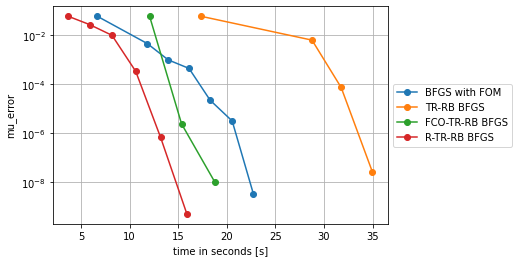

In [28]:
timings_figure = plt.figure()
%matplotlib inline
if 'BFGS' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_FOM,mu_error_FOM,'o-', label='BFGS with FOM')
if 'TR-RB-BFGS' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_19_actual[1:],mu_error_19_actual,'o-', label='TR-RB BFGS')
    plt.semilogy(times_full_9_actual[1:],mu_error_9_actual,'o-', label='FCO-TR-RB BFGS')
    plt.semilogy(times_full_ntr_actual,mu_error_ntr_actual,'o-', label='R-TR-RB BFGS')
# if 'Greedy' in optimization_methods:
#     plt.semilogy(times_full_Greed,mu_error_Greed,'o-', label='BFGS with ROM')
    
plt.xlabel('time in seconds [s]')
plt.ylabel('mu_error')
# plt.xlim([-1,30])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

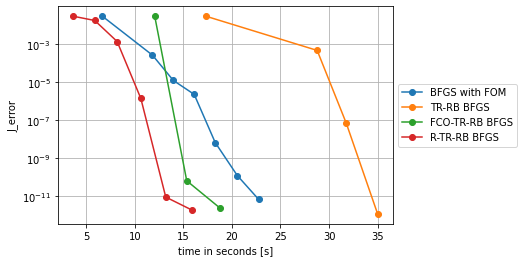

In [29]:
timings_figure = plt.figure()

if 'BFGS' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_FOM,J_error_FOM,'o-', label='BFGS with FOM')
if 'TR-RB-BFGS' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_19_actual[1:],J_error_19_actual,'o-', label='TR-RB BFGS')
    plt.semilogy(times_full_9_actual[1:],J_error_9_actual,'o-', label='FCO-TR-RB BFGS')
    plt.semilogy(times_full_ntr_actual,J_error_ntr_actual,'o-', label='R-TR-RB BFGS')
    
plt.xlabel('time in seconds [s]')
plt.ylabel('J_error')
# plt.xlim([-1,30])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

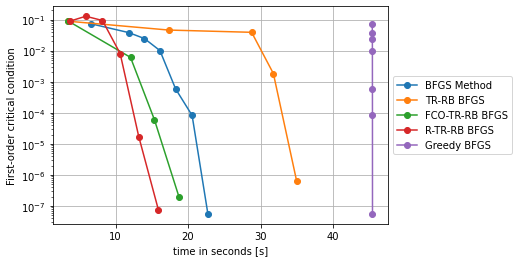

In [30]:
import tikzplotlib

timings_figure = plt.figure()
if 'BFGS' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_FOM,FOC_FOM,'o-', label='BFGS Method')
if 'TR-RB-BFGS' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_19_actual,FOC_19_actual,'o-', label='TR-RB BFGS')
    plt.semilogy(times_full_9_actual,FOC_9_actual,'o-', label='FCO-TR-RB BFGS')
    plt.semilogy(times_full_ntr_actual,FOC_ntr_actual,'o-', label='R-TR-RB BFGS')
if 'Greedy' in optimization_methods:
    plt.semilogy(times_full_Greed,FOC_Greed,'o-', label='Greedy BFGS')

plt.xlabel('time in seconds [s]')
plt.ylabel('First-order critical condition')
# plt.xlim([-1,30])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

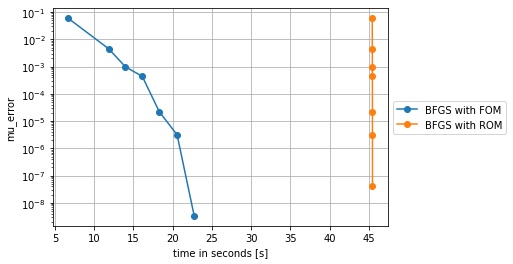

In [25]:
timings_figure = plt.figure()

if 'BFGS' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_FOM,mu_error_FOM,'o-', label='BFGS with FOM')
# if 'TR-RB-BFGS' in optimization_methods or 'All' in optimization_methods:
#     plt.semilogy(times_full_19_actual[1:],mu_error_19_actual,'o-', label='TR-RB BFGS')
#     plt.semilogy(times_full_9_actual[1:],mu_error_9_actual,'o-', label='TR-RB BFGS enrich anyway')
#     plt.semilogy(times_full_ntr_actual,mu_error_ntr_actual,'o-', label='R-TR-RB BFGS')
if 'Greedy' in optimization_methods:
    plt.semilogy(times_full_Greed,mu_error_Greed,'o-', label='BFGS with ROM')
    
plt.xlabel('time in seconds [s]')
plt.ylabel('mu_error')
# plt.xlim([-1,30])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

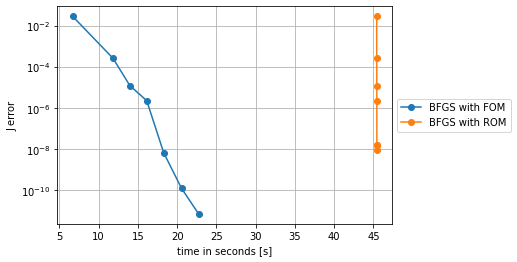

In [26]:
timings_figure = plt.figure()

if 'BFGS' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_FOM,J_error_FOM,'o-', label='BFGS with FOM')
# if 'TR-RB-BFGS' in optimization_methods or 'All' in optimization_methods:
#     plt.semilogy(times_full_19_actual[1:],mu_error_19_actual,'o-', label='TR-RB BFGS')
#     plt.semilogy(times_full_9_actual[1:],mu_error_9_actual,'o-', label='FCO-TR-RB BFGS')
#     plt.semilogy(times_full_ntr_actual,mu_error_ntr_actual,'o-', label='R-TR-RB BFGS')
if 'Greedy' in optimization_methods:
    plt.semilogy(times_full_Greed,J_error_Greed,'o-', label='BFGS with ROM')
    
plt.xlabel('time in seconds [s]')
plt.ylabel('J error')
# plt.xlim([-1,30])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Optimization path

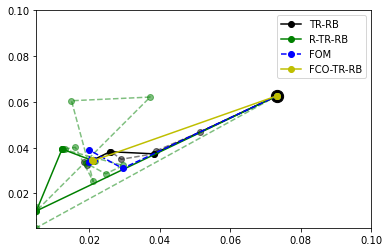

In [27]:
import tikzplotlib

fig1 = plt.figure()

mu_start = vis_mu.to_numpy()
x = []
y = []
x.append(mu_start[0])
y.append(mu_start[1])
for mu_k in mus_19:
    if isinstance(mu_k, dict):
        mu_k = mu_k.to_numpy()
    x.append(mu_k[0])
    y.append(mu_k[1])
plt.plot(x,y,'o-k', label='TR-RB')
x = []
y = []
x.append(mu_start[0])
y.append(mu_start[1])
for mus in data_19['all_mus']:
    for mu_k in mus:
        if isinstance(mu_k, dict):
            mu_k = mu_k.to_numpy()
        x.append(mu_k[0])
        y.append(mu_k[1])
plt.plot(x,y,'o--k', alpha=0.5)
x = []
y = []
x.append(mu_start[0])
y.append(mu_start[1])
for mu_k in mus_ntr:
    if isinstance(mu_k, dict):
        mu_k = mu_k.to_numpy()
    x.append(mu_k[0])
    y.append(mu_k[1])
plt.plot(x,y,'o-g', label='R-TR-RB')
x = []
y = []
x.append(mu_start[0])
y.append(mu_start[1])
for mus in data_ntr['all_mus']:
    for mu_k in mus:
        if isinstance(mu_k, dict):
            mu_k = mu_k.to_numpy()
        x.append(mu_k[0])
        y.append(mu_k[1])
plt.plot(x,y,'o--g', alpha=0.5)
x = []
y = []
x.append(mu_start[0])
y.append(mu_start[1])
for mu_k in mus_FOM:
    if isinstance(mu_k, dict):
        mu_k = mu_k.to_numpy()
    x.append(mu_k[0])
    y.append(mu_k[1])
plt.plot(x,y,'o--b', label='FOM')
mu_start = vis_mu.to_numpy()
x = []
y = []
x.append(mu_start[0])
y.append(mu_start[1])
for mu_k in mus_9:
    if isinstance(mu_k, dict):
        mu_k = mu_k.to_numpy()
    x.append(mu_k[0])
    y.append(mu_k[1])
plt.plot(x,y,'o-y', label='FCO-TR-RB')
plt.legend()
plt.xlim((0.005,0.1))
plt.ylim((0.005,0.1))
plt.scatter(mu_start[0],mu_start[1], marker='o', s=150, c='k')